Day: 0
[1, 2, 0, 0]
0.004429660545030911
[1, 2, 0, 0]
-0.00029505044988860086
[1, 2, 0, 0]
-0.005197503935195886
[1, 2, 0, 0]
-0.008558829773673988
[1, 2, 0, 0]
-0.008466293805709197
[1, 2, 0, 0]
-0.02468572702577057
[1, 2, 0, 0]
-0.01983166163568822
[1, 2, 0, 0]
-0.008800372544017731
[1, 2, 0, 0]
7.233268864566878e-05
[1, 2, 0, 0]
0.0017643742752448466
[1, 2, 0, 0]
0.004724193837120394
[1, 2, 0, 0]
0.0065990219006049865
[1, 2, 0, 0]
0.002233375331818097
[1, 2, 0, 0]
9.921864269463399e-05
[1, 2, 0, 0]
0.0010433938810602327
[1, 2, 0, 0]
0.01116657137020093
[1, 2, 0, 0]
0.02038695260562429
[1, 2, 0, 0]
0.0448113972173085
[1, 2, 0, 0]
0.03887617304964681
[1, 2, 0, 0]
0.027158801245254292
[1, 2, 0, 0]
0.02274630543986132
[1, 2, 0, 0]
0.013928281061745595
[1, 2, 0, 0]
0.00950354171057056
[1, 2, 0, 0]


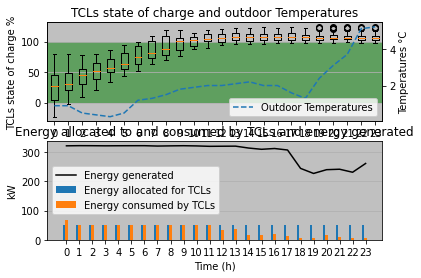

-0.004271012434417179
Total Reward: 0.12943714319807068


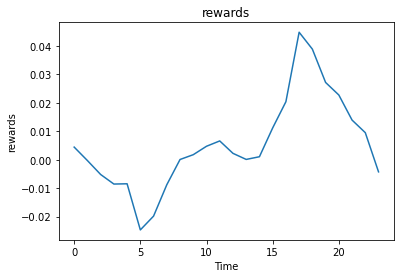

In [8]:
#!/usr/bin/env python3
#
#  tcl_env.py
#  TCL environment for RL algorithms
#


import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import gym
# Trying out if this works for others. from gym import spaces had some issues
import gym.spaces as spaces
import threading
import math

# Default parameters for
# default TCL environment.
# From Taha's code
# days range
DEFAULT_DAY0=0
DEFAULT_DAYN=1
# Power generated in the microgrid
DEFAULT_POWER_GENERATED = np.genfromtxt("wind_generation_fortum.csv", delimiter=',', skip_header=0, usecols=[-1]) / 100
DEFAULT_WIND_POWER_COST = 3.2
# Balancing market prices
DEFAULT_DOWN_REG = np.genfromtxt("down_regulation.csv", delimiter=',', skip_header=1, usecols=[-1]) / 10
DEFAULT_UP_REG = np.genfromtxt("up_regulation.csv", delimiter=',', skip_header=1, usecols=[-1]) / 10
DEFAULT_TRANSFER_PRICE_IMPORT = 0.97
DEFAULT_TRANSFER_PRICE_EXPORT = 0.09
# Length of one episode
DEFAULT_ITERATIONS = 24
# TCLs
DEFAULT_NUM_TCLS = 100
DEFAULT_AVGTCLPOWER = 1.5
DEFAULT_TEMPERATURS = np.genfromtxt("temperatures.csv",usecols=[5],skip_header=1,delimiter=',')
DEFAULT_TCL_SALE_PRICE = 3.2
DEFAULT_TCL_TMIN = 19
DEFAULT_TCL_TMAX = 25
# Price responsive loads
DEFAULT_NUM_LOADS = 150
DEFAULT_BASE_LOAD = np.array(
    [.4, .3,.2,.2,.2,.2,.3,.5,.6,.6,.5,.5,.5,.4,.4,.6,.8,1.4,1.2,.9,.8,.6,.5,.4])
DEFAULT_MARKET_PRICE = 5.48
DEFAULT_PRICE_TIERS = np.array([-3.0, -1.5, 0.0, 1.5, 3.0])
# Battery characteristics (kwh)
DEFAULT_BAT_CAPACITY=500
DEFAULT_MAX_CHARGE=250
DEFAULT_MAX_DISCHARGE=250


MAX_R = 100

# Rendering lists
SOCS_RENDER = []
LOADS_RENDER = []
BATTERY_RENDER = []
PRICE_RENDER = []
ENERGY_SOLD_RENDER = []
ENERGY_BOUGHT_RENDER = []
GRID_PRICES_BUY_RENDER = []
GRID_PRICES_SELL_RENDER = []
ENERGY_GENERATED_RENDER = []
TCL_CONTROL_RENDER = []
TCL_CONSUMPTION_RENDER = []
TOTAL_CONSUMPTION_RENDER=[]
TEMP_RENDER=[]

ACTIONS = [[i, j, k, l] for i in range(4) for j in range(5) for k in range(2) for l in range(2)]


class TCL:
    """
    Simulates an invidual TCL
    """

    def __init__(self, ca, cm, q, P, Tmin=DEFAULT_TCL_TMIN, Tmax=DEFAULT_TCL_TMAX):
        self.ca = ca
        self.cm = cm
        self.q = q
        self.P = P
        self.Tmin = Tmin
        self.Tmax = Tmax

        # Added for clarity
        self.u = 0

    def set_T(self, T, Tm):
        self.T = T
        self.Tm = Tm

    def control(self, ui=0):
        # control TCL using u with respect to the backup controller
        if self.T < self.Tmin:
            self.u = 1
        elif self.Tmin < self.T < self.Tmax:
            self.u = ui
        else:
            self.u = 0

    def update_state(self, T0):
        # update the indoor and mass temperatures according to (22)
        for _ in range(2):
            self.T += self.ca * (T0 - self.T) + self.cm * (self.Tm - self.T) + self.P * self.u + self.q
            self.Tm += self.cm * (self.T - self.Tm)
            if self.T >= self.Tmax:
                break

    """ 
    @property allows us to write "tcl.SoC", and it will
    run this function to get the value
    """

    @property
    def SoC(self):
        return (self.T - self.Tmin) / (self.Tmax - self.Tmin)


class Battery:
    # Simulates the battery system of the microGrid
    def __init__(self, capacity, useD, dissipation, rateC, maxDD, chargeE):
        self.capacity = capacity  # full charge battery capacity
        self.useD = useD  # useful discharge coefficient
        self.dissipation = dissipation  # dissipation coefficient of the battery
        self.rateC = rateC  # charging rate
        self.maxDD = maxDD  # maximum power that the battery can deliver per timestep
        self.chargeE = chargeE  # max Energy given to the battery to charge
        self.RC = 0  # remaining capacity


    def charge(self, E):
        empty = self.capacity - self.RC
        if empty <= 0:
            return E
        else:
            self.RC += self.rateC * min(E,self.chargeE)
            leftover = self.RC - self.capacity + max(E-self.chargeE,0)
            self.RC = min(self.capacity, self.RC)
            return max(leftover, 0)

    def supply(self, E):
        remaining = self.RC
        self.RC -= min(E, remaining,self.maxDD)
        self.RC = max(self.RC, 0)
        return min(E, remaining,self.maxDD) * self.useD

    def dissipate(self):
        self.RC = self.RC * math.exp(- self.dissipation)

    @property
    def SoC(self):
        return self.RC / self.capacity

    def reset(self):
        self.RC=0


class Grid:
    def __init__(self, down_reg,up_reg, exp_fees, imp_fees):
        self.sell_prices = down_reg
        self.buy_prices = up_reg
        self.exp_fees=exp_fees
        self.imp_fees = imp_fees
        self.time = 0

    def sell(self, E):
        return (self.sell_prices[self.time] + self.exp_fees) * E

    def buy(self, E):
        return -(self.buy_prices[self.time] + self.imp_fees) * E

    #
    # def get_price(self,time):
    #     return self.prices[time]

    def set_time(self, time):
        self.time = time

    def total_cost(self,prices, energy):
        return sum(prices * energy / 100 + self.imp_fees * energy)

class Generation:
    def __init__(self, generation):
        self.power = generation


    def current_generation(self, time):
        # We consider that we have 2 sources of power a constant source and a variable source
        return self.power[time]


class Load:
    def __init__(self, price_sens, base_load, max_v_load,patience):
        self.price_sens = max(0,price_sens)
        self.orig_price_sens = max(0,price_sens)
        self.base_load = base_load
        self.max_v_load = max_v_load
        self.response = 0
        self.shifted_loads={}
        self.patience=max(patience,1)
        self.dr_load=0

    def react(self, price_tier , time_day):
        self.dr_load=self.base_load[time_day]
        response = self.price_sens * (price_tier - 2)
        if response != 0 :
            self.dr_load -= self.base_load[time_day] * response
            self.shifted_loads[time_day] = self.base_load[time_day] * response
        for k in list(self.shifted_loads):
            probability_of_execution = -self.shifted_loads[k]*(price_tier - 2) + (time_day-k)/self.patience
            if random.random()<=probability_of_execution:
                self.dr_load+=self.shifted_loads[k]
                del self.shifted_loads[k]

    def load(self):
        return max(self.dr_load, 0)


class MicroGridEnv(gym.Env):
    def __init__(self,**kwargs):

        # Get number of iterations and TCLs from the
        # parameters (we have to define it through kwargs because
        # of how Gym works...)
        self.iterations = kwargs.get("iterations", DEFAULT_ITERATIONS)
        self.num_tcls = kwargs.get("num_tcls", DEFAULT_NUM_TCLS)        
        self.avg_tcl_power = kwargs.get("tcl_power", DEFAULT_AVGTCLPOWER)
        self.tcl_sale_price = kwargs.get("tcl_price", DEFAULT_TCL_SALE_PRICE)
        self.num_loads = kwargs.get("num_loads", DEFAULT_NUM_LOADS)
        self.typical_load = kwargs.get("base_load", DEFAULT_BASE_LOAD)
        self.market_price = kwargs.get("normal_price", DEFAULT_MARKET_PRICE)
        self.temperatures = kwargs.get("temperatures", DEFAULT_TEMPERATURS)
        self.price_tiers = kwargs.get("price_tiers", DEFAULT_PRICE_TIERS)
        self.day0 = kwargs.get("day0", DEFAULT_DAY0)
        self.dayn = kwargs.get("dayn", self.day0+1)
        self.power_cost = kwargs.get("power_cost", DEFAULT_WIND_POWER_COST)
        self.down_reg = kwargs.get("down_reg", DEFAULT_DOWN_REG)
        self.up_reg = kwargs.get("up_reg", DEFAULT_UP_REG)
        self.imp_fees = kwargs.get("imp_fees", DEFAULT_TRANSFER_PRICE_IMPORT)
        self.exp_fees = kwargs.get("exp_fees", DEFAULT_TRANSFER_PRICE_EXPORT)
        self.bat_capacity = kwargs.get("battery_capacity", DEFAULT_BAT_CAPACITY)
        self.max_discharge = kwargs.get("max_discharge", DEFAULT_MAX_DISCHARGE)
        self.max_charge = kwargs.get("max_charge", DEFAULT_MAX_CHARGE)

        # The current day: pick randomly
        # self.day = random.randint(self.day0, self.dayn-1)
        self.day = self.day0
        # The current timestep
        self.time_step = 0

        # The cluster of TCLs to be controlled.
        # These will be created in reset()
        self.tcls_parameters = []
        # The cluster of loads.
        # These will be created in reset()
        self.loads_parameters = []

        self.generation = Generation(kwargs.get("generation_data", DEFAULT_POWER_GENERATED))
        self.grid = Grid(down_reg=self.down_reg,up_reg=self.up_reg, exp_fees=self.exp_fees, imp_fees=self.imp_fees)
        self.battery = Battery(capacity=self.bat_capacity, useD=0.9, dissipation=0.001, rateC=0.9, maxDD=self.max_discharge, chargeE=self.max_charge)

        self.tcls = [self._create_tcl(*self._create_tcl_parameters()) for _ in range(self.num_tcls)]
        self.loads = [self._create_load(*self._create_load_parameters()) for _ in range(self.num_loads)]

        self.action_space_sep = spaces.Box(low=0, high=1, dtype=np.float32,
                                       shape=(13,))
        self.action_space = spaces.Discrete(80)

        # Observations: A vector of TCLs SoCs + loads +battery soc+ power generation + price + temperature + time of day
        self.observation_space = spaces.Box(low=-100, high=100, dtype=np.float32,
                                            shape=(self.num_tcls + 7,))

    def _create_tcl_parameters(self):
        """
                Initialize one TCL randomly with given T_0,
                and return it. Copy/paste from Taha's code
                """
        # Hardcoded initialization values to create
        # bunch of different TCLs
        ca = random.normalvariate(0.004, 0.0008)
        cm = random.normalvariate(0.3, 0.004)
        q = random.normalvariate(0, 0.01)
        P = random.normalvariate(self.avg_tcl_power, 0.01)
        init_temp = random.uniform(15,24)
        return [ca, cm, q, P,init_temp]

    def _create_tcl(self, ca, cm, q, P, init_temp):
        tcl = TCL(ca, cm, q, P)
        tcl.set_T(init_temp, init_temp)
        return tcl

    def _create_load_parameters(self):
        """
        Initialize one load randomly,
        and return it.
        """
        # Hardcoded initialization values to create
        # bunch of different loads

        price_sensitivity = random.normalvariate(0.4, 0.3)
        max_v_load = random.normalvariate(0.4, 0.01)
        patience= int(random.normalvariate(10,6))
        return [price_sensitivity, max_v_load,patience]

    def _create_load(self, price_sensitivity, max_v_load,patience):
        load = Load(price_sensitivity, base_load=self.typical_load, max_v_load=max_v_load, patience=patience)
        return load


    def _build_state(self):
        """
        Return current state representation as one vector.
        Returns:
            state: 1D state vector, containing state-of-charges of all TCLs, Loads, current battery soc, current power generation,
                   current temperature, current price and current time (hour) of day
        """
        # SoCs of all TCLs binned + current temperature + current price + time of day (hour)
        socs = np.array([tcl.SoC for tcl in self.tcls])
        # Scaling between 0 and 1
        # We need to standardize the generation and the price
        # Minimum soc is -1
        socs = (socs+np.ones(shape=socs.shape))/2
        loads = self.typical_load[(self.time_step) % self.iterations]
        loads = (loads - min(self.typical_load)) / (max(self.typical_load) - min(self.typical_load))

        current_generation = self.generation.current_generation(self.day*self.iterations+self.time_step)
        current_generation = (current_generation-
                               np.average(self.generation.power[self.day*self.iterations:self.day*self.iterations+self.iterations]))\
                              /np.std(self.generation.power[self.day*self.iterations:self.day*self.iterations+self.iterations])


        temperature = self.temperatures[self.day*self.iterations+self.time_step]
        temperature = (temperature-
                       min(self.temperatures[self.day*self.iterations:self.day*self.iterations+self.iterations]))\
                      /(max(self.temperatures[self.day*self.iterations:self.day*self.iterations+self.iterations])
                        -min(self.temperatures[self.day*self.iterations:self.day*self.iterations+self.iterations]))

        price = self.grid.buy_prices[self.day*self.iterations+self.time_step]
        price = (price -
                 np.average(self.grid.buy_prices[self.day*self.iterations:self.day*self.iterations+self.iterations])) \
                / np.std(self.grid.buy_prices[self.day*self.iterations:self.day*self.iterations+self.iterations])

        price_grid_sell = self.grid.sell_prices[self.day*self.iterations+self.time_step]
        price_grid_sell = (price_grid_sell -
                 np.average(self.grid.sell_prices[self.day*self.iterations:self.day*self.iterations + self.iterations])) \
                / np.std(self.grid.sell_prices[self.day*self.iterations:self.day*self.iterations+self.iterations])

        high_price = min(self.high_price/4,1)

        time_step = (self.time_step)/(self.iterations-1)

        state = np.concatenate((socs, [loads, high_price, time_step,self.battery.SoC, current_generation,
                         price,
                         price_grid_sell ]))
        return state

    def _build_info(self):
        """
        Return dictionary of misc. infos to be given per state.
        Here this means providing forecasts of future
        prices and temperatures (next 24h)
        """
        temp_forecast = np.array(self.temperatures[self.time_step + 1:self.time_step + self.iterations+1])
        return {"temperature_forecast": temp_forecast,
                "forecast_times": np.arange(0, self.iterations)}

    def _compute_tcl_power(self):
        """
        Return the total power consumption of all TCLs
        """
        return sum([tcl.u * tcl.P for tcl in self.tcls])

    def step(self, action):
        """
        Arguments:
            action: A list.

        Returns:
            state: Current state
            reward: How much reward was obtained on last action
            terminal: Boolean on if the game ended (maximum number of iterations)
            info: None (not used here)
        """
        if type(action) is not list:
            print(action)
            action = ACTIONS[action]

        self.grid.set_time(self.day*self.iterations + self.time_step)
        reward = 0
        # Update state of TCLs according to action

        tcl_action = action[0]
        price_action = action[1]
        self.high_price += price_action - 2
        if self.high_price > 4:
            price_action = 2
            self.high_price = 4

        energy_deficiency_action = action[2]
        energy_excess_action = action[3]
        # Get the energy generated by the DER
        available_energy = self.generation.current_generation(self.day*self.iterations + self.time_step)
        # Calculate the cost of energy produced from wind turbines
        reward-= available_energy * self.power_cost / 100
        # We implement the pricing action and we calculate the total load in response to the price
        for load in self.loads:
            load.react(price_tier=price_action, time_day=self.time_step)

        total_loads = sum([l.load() for l in self.loads])
        # print("Total loads",total_loads)
        # We fulfilled the load with the available energy.
        available_energy -= total_loads
        # Constraint of charging too high prices

        # We calculate the return based on the sale price.
        self.sale_price = self.price_tiers[price_action] + self.market_price
        # We increment the reward by the amount of return
        # Division by 100 to transform from cents to euros
        reward += total_loads * (self.sale_price) / 100


        # Distributing the energy according to priority
        sortedTCLs = sorted(self.tcls, key=lambda x: x.SoC)
        # print(tcl_action)
        control = max(min(tcl_action * self.num_tcls * self.avg_tcl_power / 3, available_energy), 0)
        self.control = control

        for tcl in sortedTCLs:
            if control > 0:
                tcl.control(1)
                control -= tcl.P * tcl.u
            else:
                tcl.control(0)
            tcl.update_state(self.temperatures[self.day*self.iterations + self.time_step])


        available_energy -= self._compute_tcl_power()
        reward += self._compute_tcl_power() * self.tcl_sale_price / 100
        # print("Available energy:", available_energy)
        if available_energy > 0:
            if energy_excess_action:
                available_energy = self.battery.charge(available_energy)
                # print("available energy after charging the battery", available_energy)
                reward += self.grid.sell(available_energy) / 100
            else:
                reward += self.grid.sell(available_energy) / 100
            self.energy_sold = available_energy
            self.energy_bought = 0

        else:
            if energy_deficiency_action:
                available_energy += self.battery.supply(-available_energy)
                # print("after energy was taken from battery", available_energy)
            self.energy_bought = -available_energy
            reward += self.grid.buy(self.energy_bought) / 100
            self.energy_sold = 0

        # Proceed to next timestep.
        self.time_step += 1
        # Build up the representation of the current state (in the next timestep)
        state = self._build_state()


        terminal = self.time_step == self.iterations
        # if terminal:

        #     # # reward if battery is charged
        #     # reward += abs(reward * self.battery.SoC / 2)
        info = self._build_info()
        return state, reward/MAX_R , terminal, info

    def reset(self,day=None):
        """
        Create new TCLs, and return initial state.
        Note: Overrides previous TCLs
        """
        if day == None:
            self.day= self.day0
        else:
            self.day = day
        print("Day:", self.day)
        self.time_step = 0

        self.high_price = 0

        return self._build_state()

    def reset_all(self,day=None):
        """
        Create new TCLs, and return initial state.
        Note: Overrides previous TCLs
        """
        if day == None:
            # self.day = random.randint(self.day0, self.dayn-1)
            self.day= self.day0
        else:
            self.day = day
        print("Day:", self.day)
        self.time_step = 0
        self.battery.reset()
        self.high_price = 0
        self.tcls.clear()
        self.loads.clear()
        self.tcls = [self._create_tcl(*self._create_tcl_parameters()) for _ in range(self.num_tcls)]
        self.loads = [self._create_load(*self._create_load_parameters()) for _ in range(self.num_loads)]


        return self._build_state()

    def render(self,name=''):
        SOCS_RENDER.append([tcl.SoC*100 for tcl in self.tcls])
        LOADS_RENDER.append([l.load() for l in self.loads])
        PRICE_RENDER.append(self.sale_price)
        BATTERY_RENDER.append(self.battery.SoC)
        ENERGY_GENERATED_RENDER.append(self.generation.current_generation(self.day*self.iterations+self.time_step-1))
        ENERGY_SOLD_RENDER.append(self.energy_sold)
        ENERGY_BOUGHT_RENDER.append(self.energy_bought)
        GRID_PRICES_BUY_RENDER.append(self.grid.buy_prices[self.day * self.iterations + self.time_step-1])
        GRID_PRICES_SELL_RENDER.append(self.grid.sell_prices[self.day * self.iterations + self.time_step-1])
        TCL_CONTROL_RENDER.append(self.control)
        TCL_CONSUMPTION_RENDER.append(self._compute_tcl_power())
        TOTAL_CONSUMPTION_RENDER.append(self._compute_tcl_power()+np.sum([l.load() for l in self.loads]))
        TEMP_RENDER.append(self.temperatures[self.day*self.iterations+self.time_step-1])
        if self.time_step==self.iterations:
            fig=plt.figure()
            # ax = pyplot.axes()
            ax = plt.subplot(2, 1, 1)
            plt.axhspan(0, 100, facecolor='g', alpha=0.5)

            ax.set_facecolor("silver")
            ax.yaxis.grid(True)

            ax.set_ylabel("TCLs state of charge %")
            ax.boxplot(SOCS_RENDER, positions=range(24))

            ax1 = ax.twinx()
            ax1.set_ylabel("Temperatures °C")
            ax1.plot(np.array(TEMP_RENDER), '--')
            plt.title("TCLs state of charge and outdoor Temperatures")
            plt.xlabel("Time (h)")
            plt.legend(["Outdoor Temperatures"], loc='lower right')
            # plt.show()

            ax = plt.subplot(2, 1, 2)
            ax.set_facecolor("silver")
            ax.set_ylabel("kW")
            ax.set_xlabel("Time (h)")
            ax.yaxis.grid(True)
            ax.plot(ENERGY_GENERATED_RENDER, color='k')
            ax.bar(x=np.array(np.arange(self.iterations)) - 0.2, height=TCL_CONTROL_RENDER, width=0.2)
            ax.bar(x=np.array(np.arange(self.iterations)), height=TCL_CONSUMPTION_RENDER, width=0.2)
            plt.xticks( np.array(np.arange(self.iterations)) )
            plt.title("Energy allocated to and consumed by TCLs and energy generated")
            plt.legend(['Energy generated','Energy allocated for TCLs', 'Energy consumed by TCLs'])
            plt.xlabel("Time (h)")
            plt.ylabel("kW")
            plt.show()

            # ax = plt.axes()
            # ax.set_facecolor("silver")
            # ax.yaxis.grid(True)
            # plt.plot(PRICE_RENDER,color='k')
            # plt.title("SALE PRICES")
            # plt.xlabel("Time (h)")
            # plt.ylabel("€ cents")
            # plt.show()
            #
            # ax = plt.axes()
            # ax.set_facecolor("silver")
            # ax.set_xlabel("Time (h)")
            # ax.yaxis.grid(True)
            # plt.plot(np.array(BATTERY_RENDER),color='k')
            # plt.title("ESS SOC")
            # plt.xlabel("Time (h)")
            # # ax4.set_ylabel("BATTERY SOC")
            # plt.show()
            #
            #
            # ax = plt.axes()
            # ax.set_facecolor("silver")
            # ax.set_xlabel("Time (h)")
            # ax.set_ylabel("kWh")
            # ax.yaxis.grid(True)
            # plt.plot(np.array(TOTAL_CONSUMPTION_RENDER), color='k')
            # plt.title("Demand")
            # plt.xlabel("Time (h)")
            # plt.show()
            #
            #
            #
            # ax = plt.axes()
            # ax.set_facecolor("silver")
            # ax.set_xlabel("Time (h)")
            # ax.yaxis.grid(True)
            # plt.plot(np.array(self.typical_load), color='k')
            # plt.title("Expected Individual basic load (L_b)")
            # plt.xlabel("Time (h)")
            # plt.ylabel("kWh")
            # plt.show()
            #
            # ax = plt.axes()
            # ax.set_facecolor("silver")
            # ax.set_ylabel("kW")
            # ax.set_xlabel("Time (h)")
            # ax.yaxis.grid(True)
            # plt.boxplot(np.array(LOADS_RENDER).T)
            # plt.title("Hourly residential loads")
            # plt.xlabel("Time (h)")
            # plt.show()
            #
            #
            #
            # ax = plt.axes()
            # ax.set_facecolor("silver")
            # ax.yaxis.grid(True)
            # plt.plot(np.array(ENERGY_GENERATED_RENDER),color='k')
            # plt.title("ENERGY GENERATED")
            # plt.xlabel("Time (h)")
            # plt.ylabel("kW")
            # plt.show()
            #
            # ax = plt.axes()
            # ax.set_facecolor("silver")
            # ax.yaxis.grid(True)
            # # ax.axis(ymin=0,ymax=610)
            # ax.bar(x=np.array(np.arange(self.iterations)),height=np.array(ENERGY_SOLD_RENDER),color='navy', width=0.8)
            # ax.bar(x=np.array(np.arange(self.iterations)),height=np.array(ENERGY_BOUGHT_RENDER),color='darkred', width=0.8)
            # ax.set_xlabel("Time (h)")
            # ax.set_ylabel("Energy Exchanged kWh")
            # ax.legend(['Energy sold', 'Energy purchased'],loc='upper left')
            # # pyplot.show()
            #
            # ax1=ax.twinx()
            # ax1.plot(np.array(GRID_PRICES_BUY_RENDER),color='red')
            # ax1.plot(np.array(GRID_PRICES_SELL_RENDER), color='green')
            # ax1.set_ylabel("GRID PRICES € cents")
            # ax1.legend(['Buying prices','Selling prices'],loc='upper right')
            # plt.show()






            # np.save(name + 'Cost' + str(self.day) + '.npy', self.grid.total_cost(np.array(GRID_PRICES_RENDER),np.array(ENERGY_BOUGHT_RENDER)))
            # np.save(name + 'Energy_bought_sold' + str(self.day) + '.npy', np.array(ENERGY_BOUGHT_RENDER)-np.array(ENERGY_SOLD_RENDER))
            # np.save(name+'TOTAL_Consumption'+str(self.day)+'.npy' , TOTAL_CONSUMPTION_RENDER)
            SOCS_RENDER.clear()
            LOADS_RENDER.clear()
            PRICE_RENDER.clear()
            BATTERY_RENDER.clear()
            GRID_PRICES_BUY_RENDER.clear()
            GRID_PRICES_SELL_RENDER.clear()
            ENERGY_BOUGHT_RENDER.clear()
            ENERGY_SOLD_RENDER.clear()
            ENERGY_GENERATED_RENDER.clear()
            TCL_CONTROL_RENDER.clear()
            TCL_CONSUMPTION_RENDER.clear()
            TOTAL_CONSUMPTION_RENDER.clear()
            TEMP_RENDER.clear()

    def close(self):
        """
        Nothing to be done here, but has to be defined
        """
        return

    def seedy(self, s):
        """
        Set the random seed for consistent experiments
        """
        random.seed(s)
        np.random.seed(s)


if __name__ == '__main__':
    # Testing the environment
    # Initialize the environment
    env = MicroGridEnv()
    env.seedy(1)
    # Save the rewards in a list
    rewards = []
    # reset the environment to the initial state
    state = env.reset()
    # Call render to prepare the visualization

    # Interact with the environment (here we choose random actions) until the terminal state is reached
    while True:
        # Pick an action from the action space (here we pick an index between 0 and 80)
        # action = env.action_space.sample()
        # action =[np.argmax(action[0:4]),np.argmax(action[4:9]),np.argmax(action[9:11]),np.argmax(action[11:])]
        action=[1,2,0,0]
        # Using the index we get the actual action that we will send to the environment
        # print(ACTIONS[action])
        print(action)
        # Perform a step in the environment given the chosen action
        # state, reward, terminal, _ = env.step(action)
        state, reward, terminal, _ = env.step(list(action))
        env.render()
        print(reward)
        rewards.append(reward)
        if terminal:
            break
    print("Total Reward:", sum(rewards))

    # Plot the TCL SoCs
    states = np.array(rewards)
    plt.plot(rewards)
    plt.title("rewards")
    plt.xlabel("Time")
    plt.ylabel("rewards")
    plt.show()



In [10]:
MicroGridEnv().action_space.sample()

54